# Homework 4 from Martin Gräf and Richard Baumann

In this Homework we look at the error analysis of the markov chain, that we talked about in the last homework. Therefore as a start we use the artificial hamiltonian, the equations of motion, the estimate of the magnetization, the leapfrog algorithm and the hybrid monte Carlo simulation, that were established in the last homework. Therefore the next lines are identical to the ones in the last homework.

In [40]:
import sys
import os
import io
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import scipy.special as sp

In [41]:
#The magnetization as defined in exercise 3
def O_magnetization(phi, N, beta_J, beta_h):
    return(np.tanh(beta_h+phi))

In [42]:
# The artificial Hamiltonian as defined in exercise 3
def hamiltonian_artificial(p , phi, N, beta_J, beta_h):
    return ((p**2/2)+(phi**2/(2*beta_J))-N*np.log(2*np.cosh(phi+beta_h)))

# phi dot as defined in exercise 3
def phi_dot(p , phi, N, beta_J, beta_h):
    return p

# p dot as defined in exercise 3
def p_dot(p , phi, N, beta_J, beta_h):
    return (-(phi/beta_J)+(N*np.tanh(phi+beta_h)))

In [43]:
# Here could also be a parameter called trajLength, but on the exercise sheet
# it was given that this is supposed to be 1.
def leapfrog(p_start, phi_start, Nmd, N, beta_J, beta_h):
    p_end = p_start
    phi_end = phi_start
    
    # epsilon = trajLength/Nmd
    epsilon = 1/Nmd
    
    # first half step of the leap frog
    phi_end = phi_end + (epsilon/2) * phi_dot(p_end,phi_end, N, beta_J, beta_h)
    
    # Now do all the steps untill the last one:
    for i in range((Nmd)-1):
        p_end = p_end + epsilon*p_dot(p_end, phi_end, N, beta_J, beta_h)
        phi_end = phi_end + epsilon*phi_dot(p_end, phi_end, N, beta_J, beta_h)
        
    # last half step
    p_end = p_end + epsilon * p_dot(p_end,phi_end, N, beta_J, beta_h)
    phi_end = phi_end + (epsilon/2) * phi_dot(p_end ,phi_end, N, beta_J, beta_h)
    
    return (p_end, phi_end)

In [44]:
def generate_phi(N, beta_J, beta_h, Nmd, nTrajs):

    # initilizing some arrays and numbers that are needed later:
    #   With the initial value for phi of 0.9
    phi_array = [0]

    # Array for saving the probabilities (to check if it drops <50%)
    prob = []
    p_step = phi_step = 0

    for traj in range(nTrajs):
        # We are sampling p from the normal distribution...
        p_start = np.random.uniform(0,1)

        # and taking the phi from the last step.
        phi_start = phi_array[-1]

        # calculate the energy before the leapfrog
        energy_start = hamiltonian_artificial(p_start, phi_start, N, beta_J, beta_h)
        
        # now do leapfrog to get new values for p and phi
        p_step, phi_step = leapfrog(p_start, phi_start, Nmd, N, beta_J, beta_h)
        
        # calculate the energy after the leapfrog
        energy_end = hamiltonian_artificial(p_step, phi_step, N, beta_J, beta_h)
        
        # now do accept/reject
        # if the random number is equal/less then the difference between the 
        # energies, accept!
        if np.random.uniform(0,1) <= np.exp(energy_start-energy_end):
            phi_array.append(phi_step)
            prob.append(1.)
        
        else:  # reject
            phi_array.append(phi_start)
            prob.append(0.)
        

    # Output if the prob is lower then 0.5, informing when it happend where
    if np.average(np.array(prob))<0.5:
        print("probability smaller then 0.5 at N=", N, " beta_J= ", beta_J, " beta_h= ", beta_h)

    # Return all Phi-Values
    return (np.array(phi_array))

## 1: Plot the first couple hundred trajectories of the MC history of {m}. How do the trajectories differ for the two MCs?

Now that we have carried over the functions form the last exercise sheet, we can start generating markov chains. The parameters, given on the exercise sheet, that should be used to generate said chains are:

* βJ = 0.1; βh = 0.5; n = 5; Nmd = 100
* βJ = 0.1; βh = 0.5; n = 5; Nmd = 4

The magnetization of the first hundred trajectories of these parameters can be seen in the diagram below:

Array 1: 0.6753515775892183 Array 2: 0.5227042546868504


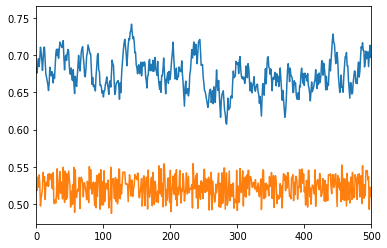

In [45]:
# Generate Phis with the given parameters, deleting thermalization (first 200 entries) and calculate the magnetization
phi_array_1 = np.delete(O_magnetization(generate_phi( 5, 0.02, 0.5, 100, 12800), 5, 0.02, 0.5),np.arange(4000))
phi_array_2 = np.delete(O_magnetization(generate_phi( 5, 0.02, 0.5, 4, 12800), 5, 0.02, 0.5),np.arange(4000))


# Plotting said values
plt.plot(phi_array_1)
plt.plot(phi_array_2)
plt.xlim(0, 500)

# Average of the values (for comparison)
print("Array 1:", np.average(phi_array_1), "Array 2:", np.average(phi_array_2))

After calculating these magnetizations, we want to estimate the errors, that emerge from this estimate. We take a look at the corrolation of our data, since we no longer have independend data but data that is dependend on the previous step. A unsefull quantity in order to analyze autocorrolations is the autocorrolation function, which is defined as:

\begin{equation}
\Gamma^{(m)}(|k-l|)=<(m(\Phi_k)-<m>)><(m(\Phi_l)-<m>)>
\end{equation}

The autocorrolation function can be implemented with:

\begin{equation}
    \bar{\Gamma}^{(m)} (\tau)= \frac{1}{\#(k, l)} \sum_{(k, l):\tau=|k-l|} (m_k-\bar{m}_N)(m_l-\bar{m}_N)
\end{equation}

An estimator for the normalized autocorrolationc is defined as:

\begin{equation}
c(\tau)= \frac{\bar{\Gamma}^{(m)} (\tau)}{\bar{\Gamma}^{(m)} (0)}
\end{equation}

In [46]:
# Implementation of the Gamma function above
def autocorrolation_function(array, tau, mean):
    sum = 0

    # Summing the individual terms
    for i in range(len(array)-tau):
        sum += (array[i]-mean)*(array[i+tau]-mean)
        
    return (sum/(len(array)-tau))

# Estimating the autocorrolation for tau (gamma(tau)/gamma(0))
def autocorrolation_estimator(array, tau, mean):
    return (autocorrolation_function(array, tau, mean)/autocorrolation_function(array, 0, mean))

## 2: Implement the straightforward estimator C($\tau$) for the normalized autocorrelation function and plot the function of C($\tau$) for your generated data sets.

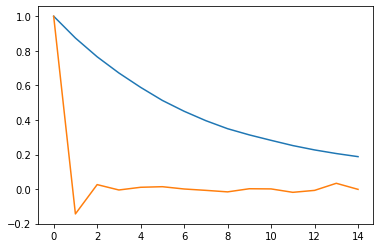

In [47]:
# Initilizing the array for the Values of the estimator
c_array=np.zeros(30).reshape(2, 15)

# Calculating the mean value for the magnetization arrays 
# (because we don`t want to calculate that term a lot of times
# in the function)
mean_array_1=np.average(phi_array_1)
mean_array_2=np.average(phi_array_2)

# Calculating the estimator values for tau \in [1, 15]
for i in range(0, 15):
    c_array[0][i]=autocorrolation_estimator(phi_array_1, i, mean_array_1)
    c_array[1][i]=autocorrolation_estimator(phi_array_2, i, mean_array_2)

# Plotting these values
plt.plot(c_array[0])
plt.plot(c_array[1])

One way to reduce autocorrolations is to block or bin data. That can reduce the neagitve effects of autocorrolation. For that we subdivide our list of values in b lists. We then take the average of that list to measure our quantity (e.g. magnetization).

In [81]:
# Bin the original data
def binning(array, b):

    binned_array = []

    # We split the array into len(array)/b big blocks
    array=np.split(array, len(array)/b)

    # And each of the blocks is averaged
    for i in range(len(array)):
        binned_array.append(np.average(array[i]))

    # Now we have an array, that is binned
    return (np.array(binned_array))

## Generate blocked data for b =2, 4, 8, 16, 32, and 64, and calculate the autocorrelation for each blocked list. Does it behave the way you expect? With the blocked lists, estimate the naive standard error with $\frac{\sigma}{\sqrt{(N/b)}}$ and observe the behavior, where $ \sigma $ is the standard deviation of the blocked list.

std at b = 2 0.0044
std at b = 4 0.0062
std at b = 8 0.0083
std at b = 16 0.011
std at b = 32 0.0153
std at b = 64 0.0212


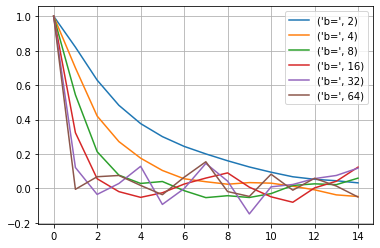

In [73]:

def plot_bin_autocorrolation_dependency(b_min, b_max, data)
for i in range (1, 7):

    for i in range(tau_max):
        c_array[i]=autocorrolation_estimator(np.array(binned_array), i, np.average(np.array(binned_array)))

    # Plot the autocorrolation of the first b-array
    plt.plot(binning(phi_array_1, 2**i, 15), label=("b=", 2**i))

    # Calculate the std of the first b-array
    print("std at b =", 2**i, round(np.std(binning(phi_array_1, 2**i, 15))/((len(phi_array_1)/2**i)**(1/2)), 4))
    
plt.legend(loc="best")
plt.grid()

### Does it behave the way you expect?

This curve looks excatly as the curve that we have seen in lecture bla, where an example for binning was introduced. 

Now we can implement the bootstrap method to estimate the error of our magnetization. The bootstrap method for a N-long list works in this way:

* 

In [50]:
def bootstrap_error(m_array, nBS):  

    # Here we will later on store the mean
    # values of the bootstrap sample
    bsmean = np.array([])

    # For the number of bootstrap samples, we:
    for bs in range (nBS):

        # Generate an array index. This array is full of numbers between 0 and len(m_array)
        # These are our random bootstap indicies
        index=np.random.randint(m_array.size,size=m_array.size)

        # Now we do a lot of stuff at once, but:
        #   We create an array. Now we go through every index in our 
        #   index array, that we created before. Corresponding to the integer in index the 
        #   index-th entry of m_array is added to our created array. We then take the main 
        #   of this array and add it to our array called bsmean.
        bsmean = np.append(bsmean,np.array([m_array[index[i]] for i in range(m_array.size)]).mean())
    
    # The error, that is estimated by bootstrap is the std of our bsmean array.
    return bsmean.std()

Now we can look at the stability of the error as a function of $ N_{bs} $. For that we just calculate some samples of an error estimation with different values for $ N_{bs} $.

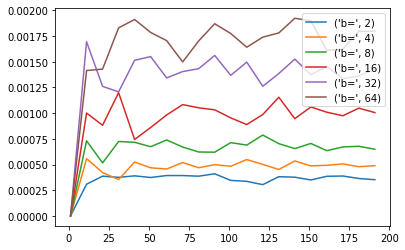

In [51]:
def stability(array, b):

    # Initilizing different numbers for the ammount of bootstrap samples
    nBs_array=np.arange(1, 200, 10)

    # Initilizing an empty array for the errors that we will estimate using bootstrap
    error_array=np.zeros(len(nBs_array))

    for i in range(len(error_array)):
        # The bootstrap error is estimated using the first splitted 
        # array and different numbers of bootstrap samples
        error_array[i]=bootstrap_error(binning(array, b), nBs_array[i])

    # Here we are plotting the dependency of estimate of the error 
    # on the ammount of bootstrap samples 
    plt.plot(nBs_array, error_array, label=("b=", b))

# For b= 2, 4, 8, 16, 31, 64 estimate bootstrap error
for i in range(1, 7):
    stability(phi_array_1, 2**i)
    plt.legend(loc="best")
    

In the diagram above, we can see, that the solution is pretty stable starting at a certain point. This point sees to be about 25 for every b. Now we can estimate the error for our blocked m:

In [52]:

for i in range (1, 7):
    print("std at b =", 2**i, round(bootstrap_error(np.array_split(phi_array_1, i)[0], 25), 4))

std at b = 2 0.0002
std at b = 4 0.0004
std at b = 8 0.0004
std at b = 16 0.0005
std at b = 32 0.0005
std at b = 64 0.0006
